# Enunciado
## Cálculo de la duración de un proyecto usando el Método de Montecarlo

>Considere el proyecto cuya información se adjunta.
> 1. Dibuje el grafo PERT del proyecto.
> 2. Determine las ecuaciones de los tiempos tempranos de cada nodo.
> 3. Calcule, utilizando las ecuaciones, los tiempos tempranos de cada nodo.
> 4. Determina la duración media y la desviación típica de la duración del proyecto.
> 5. Determine la duración para una probabilidad de completar antes el proyecto del 98%. 

In [1]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib notebook

datos_enunciado = pd.DataFrame([
#  actividad, nodo_inicial, nodo_final, duracion media, desviación típica
     ('A',    0,  1,  10, 1.5 ),
     ('B',    0,  2,   5, 0.4 ),  
     ('C',    1,  4,   6, 0.8 ),
     ('D',    1,  3,   2, 0.7 ),
     ('E',    4,  5,   7, 1.8 ), 
     ('F',    3,  5,   8, 0.8 ),
     ('G',    5,  6,   4, 1.4 ),
     ('H',    2,  6,   7, 1.6 ),
     ('f1',   3,  4,   0, 0.0 ),
     ('f2',   2,  3,   0, 0.0 ),
] ,columns=['actividad', 'nodo_inicial', 'nodo_final', 'mean', 'stdev']).set_index('actividad')

datos_enunciado

,nodo_inicial,nodo_final,mean,stdev
actividad,,,,
A,0,1,10,1.5
B,0,2,5,0.4
C,1,4,6,0.8
D,1,3,2,0.7
E,4,5,7,1.8
F,3,5,8,0.8
G,5,6,4,1.4
H,2,6,7,1.6
f1,3,4,0,0.0


## Solución
### Apartado 1
> 1. Dibuje el grafo PERT del proyecto.

In [2]:
from pmule import calcula_encadenamientos, GrafoProyecto

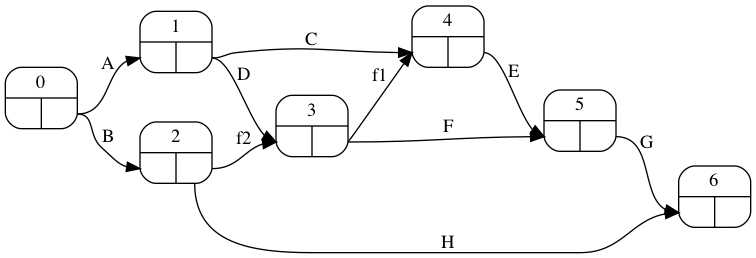

In [3]:
datos_proyecto =  datos_enunciado.copy()
proyecto = GrafoProyecto(datos_proyecto)
proyecto.pert('pert_nodos.png', duraciones=False)

### Apartado 2
> 2. Determine las ecuaciones de los tiempos tempranos de cada nodo.


$t_0 = 0$

$t_1 = t_0 + d_A$

$t_2 = t_0 + d_B$

$ t_3 = \max \begin{Bmatrix} t_1 + d_D \\ t_2 + d_{f_2} \end{Bmatrix} $

$ t_4 = \max \begin{Bmatrix} t_1 + d_C \\ t_2 + d_{f_1} \end{Bmatrix} $

$ t_5 = \max \begin{Bmatrix} t_4 + d_E \\ t_3 + d_F \end{Bmatrix} $

$ t_6 = \max \begin{Bmatrix} t_5+ d_G \\ t_2 + d_H \end{Bmatrix} $


### Generación aleatoria de las duraciones de las actividades

In [4]:
number_of_samples = 10000

In [5]:
activity_names = datos_proyecto.index
duration = pd.DataFrame([np.random.normal(size = number_of_samples,
                                          loc  = datos_proyecto.loc[task, 'mean',],
                                          scale= datos_proyecto.loc[task, 'stdev'])
                         for task in activity_names
                        ],
                        index=activity_names).T

In [6]:
duration.head()

actividad,A,B,C,D,E,F,G,H,f1,f2
0,11.471564,5.582264,4.735953,2.066401,8.517635,7.398959,3.282636,7.467166,0.0,0.0
1,9.551554,5.411445,6.856719,2.708422,7.775242,8.313575,3.245156,5.748755,0.0,0.0
2,10.624169,4.765658,5.593707,1.169107,8.274051,8.860580,3.596088,6.636675,0.0,0.0
3,12.123931,5.932333,7.190548,1.489438,8.164078,8.252450,3.549282,5.683221,0.0,0.0
4,8.160367,5.746066,6.466065,2.093435,4.769284,7.639208,3.741897,6.363536,0.0,0.0


### Cálculo de los tiempos tempranos

In [7]:
def row_max(A,B):
    return pd.concat([A,B], axis=1).max(axis=1)

In [8]:
t_early = duration.copy()
t_early.eval("""t_0 = 0

                t_1 = t_0 + A

                t_2 = t_0 + B
                
                input_D = t_1 + D
                input_f2 = t_2+ f2
                t_3 = @row_max(input_D, input_f2)
                
                input_C = t_1 + C
                input_f1 = t_3 + f1
                t_4 = @row_max(input_C, input_f1)

                input_E = t_4 + E 
                input_F = t_3 + F
                t_5 = @row_max(input_E, input_F)

                input_G = t_5 + G
                input_H = t_2 + H
                t_6 = @row_max(input_G, input_H)
                """, inplace=True)

In [9]:
nombre_nodos = ['t_'+ str(num) for num in range(7)]
t_early.loc[0:10, nombre_nodos ]

actividad,t_0,t_1,t_2,t_3,t_4,t_5,t_6
0,0,11.471564,5.582264,13.537965,16.207517,24.725152,28.007788
1,0,9.551554,5.411445,12.259976,16.408272,24.183514,27.428670
2,0,10.624169,4.765658,11.793276,16.217876,24.491927,28.088015
3,0,12.123931,5.932333,13.613369,19.314480,27.478558,31.027840
4,0,8.160367,5.746066,10.253803,14.626432,19.395716,23.137612
5,0,10.142494,4.428411,11.961598,14.830189,22.790263,30.242105
6,0,9.895841,4.841297,11.233824,16.872399,25.888309,28.966630
7,0,10.888333,4.592093,13.077333,17.262778,24.965485,29.298879
8,0,11.625102,4.457508,12.883054,17.959230,25.107271,30.711784
9,0,11.770503,5.835153,14.199909,17.679143,23.815171,29.368664


### Visualización y caracterización de la distribución de la duración del proyecto 

<IPython.core.display.Javascript object>


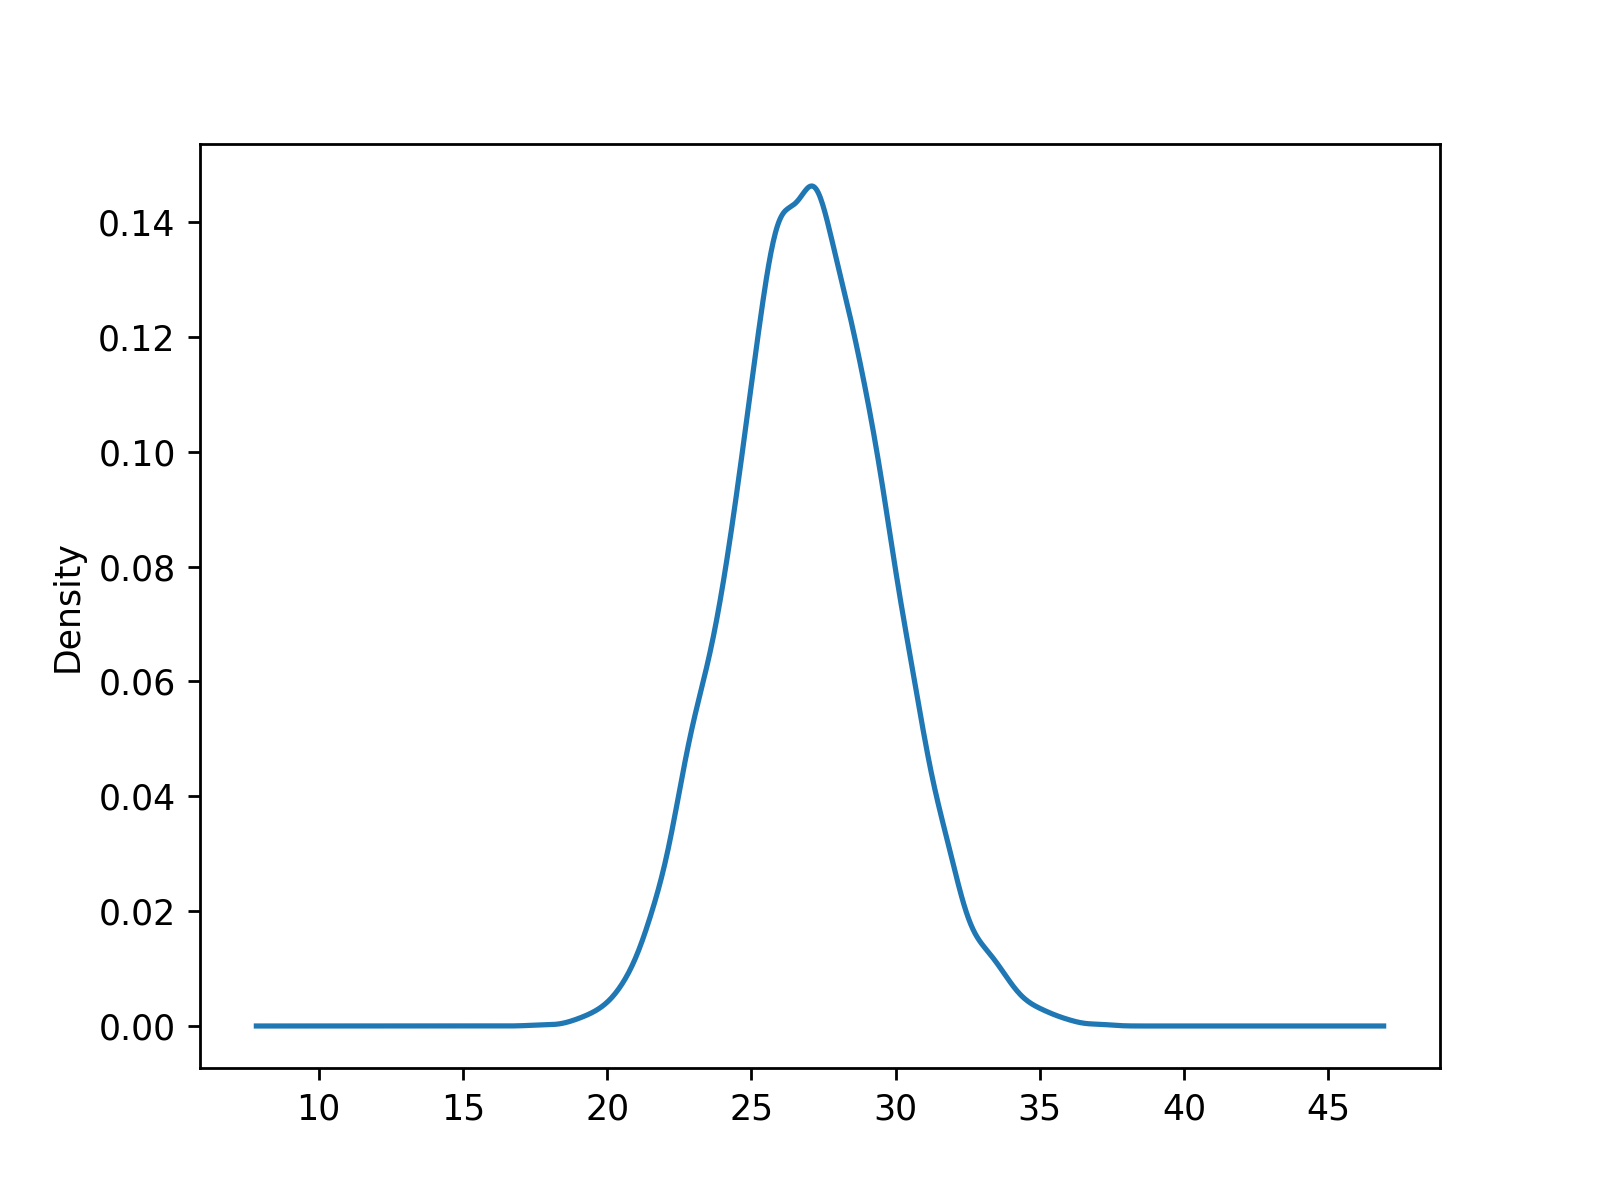

In [10]:
t_early['t_6'].plot(kind='density')

In [11]:
t_early['t_6'].describe()

count    10000.000000
mean        27.046388
std          2.716620
min         17.609965
25%         25.228962
50%         27.002223
75%         28.861827
max         37.150193
Name: t_6, dtype: float64

La duración media del proyecto es:

In [12]:
t_early['t_6'].mean()

27.046387773250498

La desviación típica de la duración del proyecto es:

In [13]:
t_early['t_6'].std()

2.7166201236518037

### Apartado 5
> 5. Determine la duración para una probabilidad de completar antes el proyecto del 98%. 

Podemos ordenar los valores en sentido ascendente y quedarnos con aquél valor superior al 98% de las muestras.

In [14]:
t_early['t_6'].sort_values(ascending=True).iloc[int(0.98*number_of_samples)]

32.878866298552964

O bien, utilizando la función `quantile`

In [15]:
t_early['t_6'].quantile(q=0.98, interpolation='higher')

32.878866298552964